Amit Chen


As usual, some prep work:

In [149]:

from IPython.core.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="dark")

THRESH_HOLD = 0.035

MEREZ = 'מרצ'

EMET = 'אמת'

BADGE_VAADA = 'סמל ועדה'

OUTSIDE_ENEVELOPS = 'מעטפות חיצוניות'

ECO_LEVEL_COL = 'eco_level'

ECO_LEVELS_AMOUNT = 10

NAME_COL = 'name'

ISO_ECNODING_FORMAT = 'iso-8859-8'

HEVRATI_CALCALI_XLSX = 'eshkol_hevrati_calcali.xlsx'

YESHOV_BADGE_COL = 'סמל ישוב'

SET_CODE_COL = "set_code"

party_acrynom_to_name_2020 ={EMET: "עבודה גשר מרצ", 'ג' : "יהדות התורה", 'ודעם'  : "הרשימה המשותפת", 'טב'  : "ימינה",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "כחול לבן", 'שס'  : "שס"}

In [150]:
raw_2020_ballots = pd.read_csv('votes per ballot 2020.csv', encoding ='iso-8859-8', index_col='שם ישוב')
raw_2020_ballots.drop(["מעטפות חיצוניות"], axis=0, inplace=True)
ballots_2020 = raw_2020_ballots.drop(BADGE_VAADA, axis=1)
ballots_2020 = ballots_2020[ballots_2020.columns[8:-1]]
ballots_2020 = ballots_2020.drop(columns='כשרים')
df_2020 = ballots_2020.copy()


In [151]:

def threshold_parties(df, thresh):
    party_ratios = df.sum().div(df.sum().sum()).sort_values(ascending=False)

    return party_ratios[party_ratios > thresh]


above_th_parties = threshold_parties(ballots_2020, 0.0325).index
df_2020_above_th = ballots_2020[above_th_parties]


### Q1
______

In [152]:

def estimate_p(data, ballots_amount, iter):
    """
    Estaimte p based on the given amounts and data

    @param data:
    @param ballots_amount:
    @param iter:
    @return:
    """
    j = 0
    p_hat = np.zeros((iter, data.shape[1]))
    j = sample_loop(ballots_amount,data,iter,j,p_hat)
    r = (j / iter)

    return p_hat, r

def sample_loop(ballots_amount, data, iter, j, p_hat):
    """
    Single sample and estimation of p_hat
    @param ballots_amount:
    @param data:
    @param iter:
    @param j:
    @param p_hat:
    @return:
    """
    k=0
    for i in range(iter):
        k+=1  
        curr_sample = data.sample(n=ballots_amount, axis=0)
        j += curr_sample.values.sum() / ballots_amount
        p_hat[i, :] = curr_sample.sum(axis=0) / curr_sample.values.sum()
    return j

In [153]:
b = 10
rounds_amount = 100
p_hat,m = estimate_p(df_2020_relevant, b, rounds_amount)

In [154]:

pjs = df_2020_above_th.sum(axis=0) / df_2020_above_th.values.sum()

p_hat_avg = np.mean(p_hat, axis=0)
p_hat_var = np.var(p_hat, axis=0)

bias_inner = np.mean(p_hat, axis=0) - np.array(pjs)
p_hat_bias_avg = np.abs(bias_inner)

dist = p_hat - np.array(pjs)
p_hat_mse = np.mean((dist) ** 2, axis=0)


### Q1.b
**Bias** : The table below describes the bias based on the phat samples ,
  We can see that the biases indeed converge to 0 as the theory declares.


In [155]:
biggest_parties=party_acrynom_to_name_2020.keys()
current_bias = pd.DataFrame(p_hat_bias_avg).T
current_bias.columns=biggest_parties
current_bias.index=["Bias"]
current_bias


,אמת,ג,ודעם,טב,ל,מחל,פה,שס
Bias,0.004422,0.007227,0.005451,0.005392,0.000623,0.001671,0.000433,0.00348


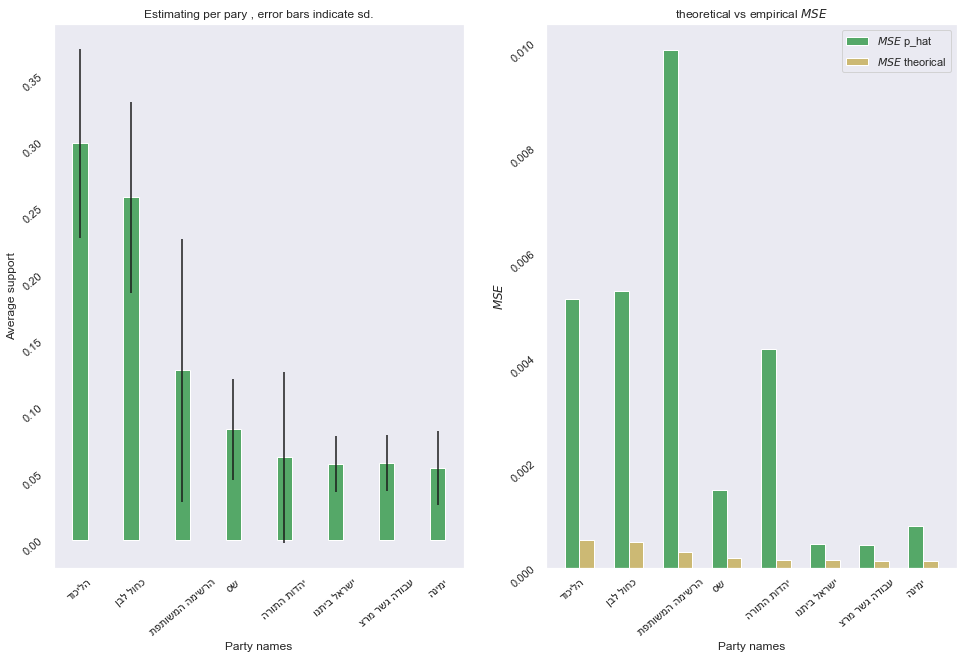

In [156]:

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 16.180339887498948482,10 
col_width = 0.3
n = 8
reverse_names_for_plots = [party_acrynom_to_name_2020[name][::-1] for name in list(above_th_parties)]
fig, ax = plt.subplots(1,2)
range_x = np.arange(n)

def plot_qhat_barplot():
    mean_p_hat = list(p_hat_avg)
    sd = np.sqrt(p_hat_var)
    ax[0].bar(range_x, mean_p_hat, col_width, color='g', yerr = sd)
    ax[0].set_title('Estimating per pary , error bars indicate sd.')
    ax[0].set_xlabel('Party names')
    ax[0].set_ylabel('Average support')
    ax[0].set_xticks(np.arange(n))
    ax[0].set_xticklabels(reverse_names_for_plots)
    ax[0].tick_params(labelrotation=40)


plot_qhat_barplot()



mse_theo = pjs * (1 - pjs) / m

def plot_MSE_comaprsion_graphs():
    bar1=ax[1].bar(np.arange(n), (p_hat_mse), col_width, color='g')
    bar2=ax[1].bar(np.arange(n) + col_width, (mse_theo), col_width, color='y')
    ax[1].set_ylabel('$MSE$')
    ax[1].set_xlabel('Party names')
    ax[1].set_title('theoretical vs empirical $MSE$')
    ax[1].set_xticks(np.arange(n))
    ax[1].set_xticklabels(reverse_names_for_plots)
    ax[1].tick_params(labelrotation=40)
    ax[1].legend((bar1[0], bar2[0]), ('$MSE$ p_hat ',
                                        '$MSE$ theorical'))
plot_MSE_comaprsion_graphs()

plt.show()


## Q2

In [157]:
def join_ballots_by_soical():
    """
    Merge dfs by different social economic criterion.
    @return:
    """
    raw = read_set_raw()
    social_df = read_set_social()
    all_df = merge_dfs(raw, social_df)
    res = all_df[above_th_parties]
    res = res.set_index(all_df.name)
    return all_df, res

def merge_dfs(raw, social_df):
    raw[NAME_COL] = raw.index
    all_df = pd.merge(left=raw, right=social_df, left_on=SET_CODE_COL, right_on=SET_CODE_COL)
    all_df = all_df.set_index(all_df[NAME_COL])
    return all_df


def read_set_social():
    social_df = pd.read_excel(HEVRATI_CALCALI_XLSX).drop(columns=NAME_COL)
    social_df[SET_CODE_COL] = pd.to_numeric(social_df[SET_CODE_COL])
    return social_df


def read_set_raw():
    raw = raw_2020_ballots.copy()
    set_codes_to_match_by = raw[YESHOV_BADGE_COL]
    raw[SET_CODE_COL] = pd.to_numeric(set_codes_to_match_by)
    return raw


merged,ballots = join_ballots_by_soical()


In [158]:





def get_Nls(df):
    Nls = []
    for i in np.arange(ECO_LEVELS_AMOUNT):
        df_i = df[df[ECO_LEVEL_COL] == i]
        Nls.append(df_i.drop(columns=[ECO_LEVEL_COL]).values.sum())
    return Nls

def p_social_est(df, iter, votes):
    df_votes, p_hat, Nls = prepare_variables(iter, df, votes)
    for i in range(iter):
        run_one_sample_iter(df_votes, p_hat, i, Nls)
    return p_hat

def run_one_sample_iter(current_df, p_hat, i, Nls):
    curr_sample = current_df.groupby(ECO_LEVEL_COL).apply(lambda s: s.sample(1)).drop(columns=['eco_level'])
    est = curr_sample.divide(curr_sample.sum(axis=1), axis=0)
    b = est.multiply(Nls, axis=0)
    p_hat[i, :] = b.sum(axis=0) / np.sum(Nls)

def prepare_variables(iters, overall_df, votes):
    p_hat = np.zeros((iters, votes.shape[1]))
    df_votes = votes.copy()
    df_votes[ECO_LEVEL_COL] = overall_df[ECO_LEVEL_COL]
    Nls = get_Nls(df_votes)
    return df_votes, p_hat, Nls


p_hat_social = p_social_est(merged, 100, ballots)

distance_probs = p_hat_social - pjs.to_numpy()
p_hat_social_mse = np.mean(distance_probs ** 2, axis=0)


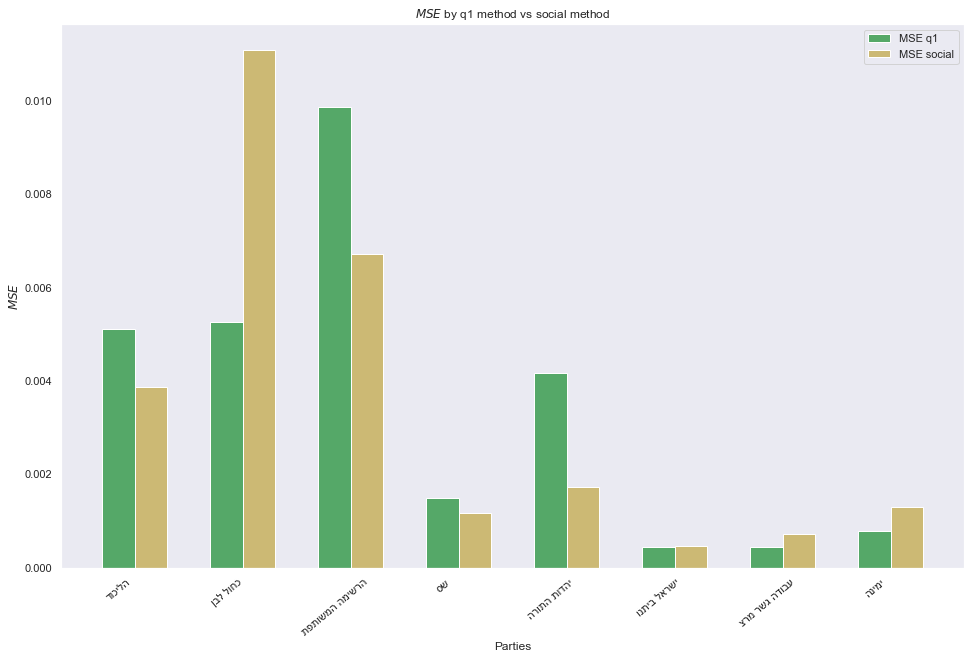

In [159]:

def mse_comparsion():
    global ax
    _, ax = plt.subplots()
    bar1 = ax.bar(np.arange(n), list(p_hat_mse), col_width, color='g')
    bar2 = ax.bar(np.arange(n) + col_width, list(p_hat_social_mse), col_width, color='y')
    ax.set_ylabel('$MSE$')
    ax.set_xlabel('Parties')
    ax.set_title('$MSE$ by q1 method vs social method')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(reverse_names_for_plots)
    plt.xticks(rotation=40)
    ax.legend((bar1[0], bar2[0]), ('MSE q1',
                                   'MSE social'))
    plt.show()


mse_comparsion()

MSE by each estimator :

In [160]:

d=pd.DataFrame(columns=["MSE"],index=["global estimator ","social estimator "])

d.iloc[0]=np.sum(p_hat_mse)
d.iloc[1]=np.sum(p_hat_social_mse)
display(d)


,MSE
global estimator,0.027571
social estimator,0.0270546


## Which method is better ?
Influencing conclusion only from the graphs is a bit ambiguous since both have majors error towards different parties.
For example , in the social estimator Kahol Lavan error stems from their high support
among rich ballots while rich ballots amount and population  is tiny compared to their counterparts ,
 therefore sampling the same amount of ballots from each economic level results
in a higher influence for the high-economic level ballots , and they mostly support Kahol Lavan.

Vadam unsual error in both estimation stems from the fact that ballots that support Vadam usually either fully
support them , or none at all. Therefore, a sample of ballots that majorly support Vadam will be *extremely* misleading
to the true underlying distribution of votes , Unlike a sample that mostly consist of ballots from Haifa from example.

Interpreting the MSE values without regarding the feature vectors size is misleading ,  the average
error per a feature can be calculated in the following way : $$\frac{\sqrt{MSE}}{parties\_num}$$


**Remark** : We had to run the code again to fix some things , and the output for the MSE came different but the idea remain the same.
Therefore inputting our values result in the following :

**global average error per feature :** $\sqrt{0.0273748}=0.1654\iff\frac{0.1654}{8}=0.02068$

**social  average error per feature :**   $\sqrt{0.0272132}=0.1649\iff\frac{0.1649}{8}=0.02062$


So we can see that the social methode estimator   manage on average to estimate the ${p_{j}}$ with $0.2062\% $ error per
party , while the social method estimator error per party is  $0.2068\% $

### Question 3


Parsing the 2019 data and fiiting him into the 2020 dataframe shape

In [161]:

df_2019b = pd.read_csv('votes per city 2019b.csv', encoding ='iso-8859-8', index_col='שם ישוב')

parse_dict = {}


for i in range(len(df_2019b.index)):
    df_indexes = df_2019b.index[i]
    df_inx_post_ptrn1 = df_indexes.replace('-',"")
    df_indexes_pst_ptrn2 = df_inx_post_ptrn1.replace("\'", "")
    df_indexes_post_ptrn3 = df_indexes_pst_ptrn2.replace("\"", "")

    parse_dict[df_2019b.index[i]] = df_indexes_post_ptrn3


Dropping the needless columns

In [162]:

df_2019b = df_2019b.rename(index=parse_dict)
df_2019b = df_2019b.drop([OUTSIDE_ENEVELOPS])
df_2019 = df_2019b.drop(BADGE_VAADA, axis=1)

df_2019 = df_2019[df_2019.columns[5:]]
df_2019 = df_2019.sort_index()
df_2019b = df_2019b.sort_index()
df_2019[EMET] = df_2019[MEREZ] + df_2019[EMET]
df_2019= df_2019.drop(columns=[MEREZ], axis=1)
df_2019['נץ'] = df_2019['כף']
df_2019 = df_2019.drop(columns=['כף'], axis=1)


Combining Merez Emet Avoda
Changing Yahadot a Tora name

Getting above threshold parties

In [163]:
above_th_parties19 = threshold_parties(df_2019, THRESH_HOLD)
above_th_parties19 = above_th_parties19.reindex(pjs.index, axis=1)

##### a

Calculating different estimates to build the needed plots.

Interoplation between the old data and our currect estimator :

In [164]:
def interpolation_p_q_alpha(q, p_hat, alpha):
    return alpha * p_hat + (1 - alpha) * q


alpha_range = np.arange(0, 1.001, 0.01)


Estiamted finals per alpha

In [165]:
estimated_finals = []
for alpha in alpha_range:
    estimated_finals.append(interpolation_p_q_alpha(above_th_parties19, p_hat_avg, alpha))


Calculating mses per alpha to create the bais variance tradeoff bar

In [166]:

alpha_size = alpha_range.size
diff_above_th_pjs = above_th_parties19 - pjs
c = np.tile(diff_above_th_pjs, (alpha_size, 1))
alpha_range_col = (1 - alpha_range).reshape(-1, 1)
biases = (alpha_range_col * c) ** 2
var_p = pjs * (1 - pjs) / m


alpha_vars = (alpha_range ** 2).reshape(-1, 1) * np.tile(var_p, (alpha_size, 1))

alphas_mse = biases + alpha_vars

Plotting MSE, squared bias and variance of the estimates:

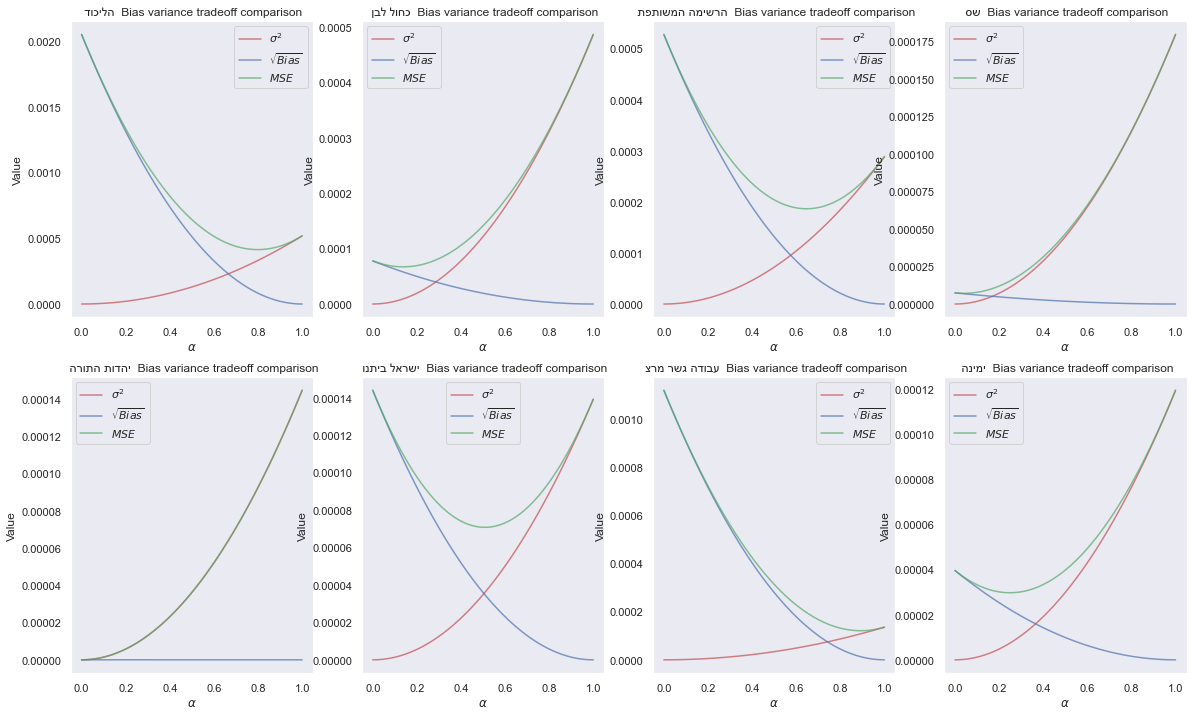

In [167]:


fig,axes = plt.subplots(ncols=4,nrows=2,figsize=(20,12))
sns.set(style="darkgrid")


def plot_tradeoff_lines_current_party():
    sns.lineplot(x=alpha_range, y=alpha_vars[:, i], color="r", alpha=0.7, label="$\sigma^2$", ax=axes.flat[i])
    sns.lineplot(x=alpha_range, y=biases[:, i], color="b", alpha=0.7, label="$\sqrt{Bias}$", ax=axes.flat[i])
    sns.lineplot(x=alpha_range, y=alphas_mse[:, i], color="g", alpha=0.7, label="$MSE$", ax=axes.flat[i])

def set_lables_axis():
    axes.flat[i].set_title(" {}  Bias variance tradeoff comparison".format(party_acrynom_to_name_2020[pjs.index[i]][::-1]))
    axes.flat[i].set_ylabel('Value')
    axes.flat[i].set_xlabel('$\\alpha$')

def set_legend():
    handles, labels = axes.flat[i].get_legend_handles_labels()
    axes.flat[i].legend(handles, labels)
    axes.flat[i].legend()

for i in range(len(above_th_parties)):
    plot_tradeoff_lines_current_party()
    set_lables_axis()
    set_legend()
plt.show()


Comparing the MSE values for different $\alpha's$

In [168]:



a=pd.DataFrame(columns=["MSE"],index=["$\\alpha ==0.5$","$\\alpha ==1$"])
a.loc["$\\alpha ==1$"]=(np.sum(alphas_mse[100]))
a.loc["$\\alpha ==0.5$"]=np.sum(alphas_mse[50])
a


,MSE
$\alpha ==0.5$,0.00149581
$\alpha ==1$,0.00201395


Yes , interpolating the previous elections into account (Bayesian inference?) Improved the results.

### Q3.B

#### Theroical MSE formula for $\hat q_j$
$
MSE(\hat q_j)= \sigma^2\alpha^2  +(1-\alpha )^2(q_j-p_j)^2
$

##### Derivative process :

$
\frac{d}{d\alpha}MSE(\hat q_j)=2\alpha\sigma^2-2(1-\alpha)(q_j-p_j)^2\iff2(1-\alpha)(q_j-p_j)^2=2\alpha\sigma^2
$

$
2(1-\alpha)(q_j-p_j)^2=2\alpha\sigma^2\iff (q_j-p_j)^2-\alpha(q_j-p_j)^2=\alpha\sigma^2
$

$
\iff (q_j-p_j)^2=\alpha (\sigma ^2)+\alpha (q_j-p_j)^2\iff \alpha ((q_j-p_j)^2+\sigma^2)=(q_j-p_j)^2
$

$
\alpha_{opt} = \frac{\left(q_{j}-p_{j}\right)^2}{\left((q_{j}-p_{j})^2+\sigma^{2}\right)}
$



#### Optimizng alpha to minimize the MSE of each party :

The following table describe the relation between the therotical alpha  and the observable alpha  for each party from the previous
question.

In [169]:
q=above_th_parties19
p=pjs

q1 = np.power(q, 2) - 2 * q * p + np.power(p, 2)
alphas_therotical = q1 / (q1 + var_p)
min_alphas_empirical_unormalzied = np.argmin(alphas_mse, axis=0)
alpha_comp=pd.DataFrame(index=["$\\alpha_{j\_opt}$","$\\alpha_{j\_observed\_opt}$"], columns=alphas_therotical.index)
alpha_comp.iloc[0]=(alphas_therotical)
alpha_comp.iloc[1]=(min_alphas_empirical_unormalzied / 100)
display(alpha_comp)


,מחל,פה,ודעם,שס,ג,ל,אמת,טב
$\alpha_{j\_opt}$,0.798149,0.137971,0.6466,0.0397003,0.000125723,0.508422,0.891969,0.248881
$\alpha_{j\_observed\_opt}$,0.8,0.14,0.65,0.04,0,0.51,0.89,0.25


#### Can we use this formula in advance?
The formula

$
\alpha_{opt} = \frac{\left(q_{j}-p_{j}\right)^2}{\left((q_{j}-p_{j})^2+\sigma^{2}\right)}
$

 includes $q_j$ , which is the value we want to estimate. If we had him in advance this whole process isn't needed.
 Therefore, we can't use this formula to indicate the best $\alpha$ value by itself.
#### Empirical means to find \alpha after observing the sample :
Empirical means as we have done
 help us to apporximate the true alpha , which we never know  , then we can use the empirical alpha's we derived to find
 the alpha that minimizes the MSE across all parties , i.e solve the following equation based on a large enough sample :

$min_{\alpha\in[0,1]}\,\,\,(var_{empirical}\left(\alpha\hat{p}+\left(1-\alpha\right)q\right)+bias_{empirical}\left(\alpha\hat{p}+\left(1-\alpha\right)q\right)^{2})$

